In [27]:
%load_ext autoreload
%autoreload 2
import sys
from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import matplotlib.pyplot as plt

LOG.propagate = False
LOG.debug("debug")
LOG.info("info")
LOG.warning("warning")
LOG.error("error")
LOG.critical("critical")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-04-15 19:49:53,464 | INFO     |: info
2024-04-15 19:49:53,465 | WARNING  |: warning
2024-04-15 19:49:53,466 | ERROR    |: error
2024-04-15 19:49:53,466 | CRITICAL |: critical


In [28]:
ble = get_ble_controller() # Get ArtemisBLEController object
ble.connect() # Connect to the Artemis Device

2024-04-15 19:49:54,019 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:89:c1:6d:24:4b
2024-04-15 19:49:59,550 | INFO     |: Connected to c0:89:c1:6d:24:4b


In [48]:
ble.send_command(CMD.ECHO, "HiHello")
output1 = ble.receive_string(ble.uuid['RX_STRING'])
print(output1)

Exception in callback notification_handler(<bleak.backen...001BD0D276C30>)(bytearray(b'R...: HiHello :)')) at C:\Users\xyx07\AppData\Local\Temp\ipykernel_36132\3046214753.py:19
handle: <Handle notification_handler(<bleak.backen...001BD0D276C30>)(bytearray(b'R...: HiHello :)')) at C:\Users\xyx07\AppData\Local\Temp\ipykernel_36132\3046214753.py:19>
Traceback (most recent call last):
  File "C:\Users\xyx07\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\xyx07\AppData\Local\Temp\ipykernel_36132\3046214753.py", line 32, in notification_handler
    label, value = reading.split(':')
    ^^^^^^^^^^^^
ValueError: too many values to unpack (expected 2)


Robot says: HiHello :)
ToF data received.
PID data received.


In [4]:
Kp = 0.03
Ki = 0.03
Kd = 0.2
minPWM = 37
maxESum = 100
cmd = str(Kp)+"|"+str(Ki)+"|"+str(Kd)+"|"+str(minPWM)+"|"+str(maxESum)
print(cmd)
ble.send_command(CMD.SET_PID_VALUE, cmd)
output1 = ble.receive_string(ble.uuid['RX_STRING'])
print(output1)

0.03|0.03|0.2|37|100
New PID values are set: 0.30, 0.30, 0.200


In [30]:
raw_message=[]
#add more arrays if needed
num = []
timeToF = [] #in seconds
distanceF = [] 
distanceS = [] 
error = []
PIDoutput = []
timePID = []

def notification_handler(uuid, byte_array):
    global distanceF,distanceS,timeToF,error,PIDoutput,timePID
    raw_message.append(byte_array)
    message = ble.bytearray_to_string(byte_array)
    if message=='ToF data received.':
        print(message)
        isPID = True
    elif message=='PID data received.':
        print(message)
    else:
        readings = message.split('|')
        num.clear()
        for reading in readings:
            label, value = reading.split(':')
            num.append(float(value))
        if len(num)==3:
            if label=="Side Distance":
                timeToF.append(num[0]/1000)
                distanceF.append(num[1])
                distanceS.append(num[2])
            elif label=="PID output":
                timePID.append(num[0]/1000)
                error.append(num[1])
                PIDoutput.append(num[2])

In [45]:
Kp = 0.07
Ki = 0.03
Kd = 0.28
minPWM = 38
maxESum = 110
cmd = str(Kp)+"|"+str(Ki)+"|"+str(Kd)+"|"+str(minPWM)+"|"+str(maxESum)
print(cmd)
ble.send_command(CMD.SET_PID_VALUE, cmd)
output1 = ble.receive_string(ble.uuid['RX_STRING'])
print(output1)

0.07|0.03|0.28|38|110
New PID values are set: 0.70, 0.30, 0.280


In [46]:
ble.start_notify(ble.uuid['RX_STRING'], notification_handler)

In [47]:
clear_data()
ble.send_command(CMD.LINEAR_PID, "300|255") 
#set distance 300 mm | initial speed 255 full PWM

In [49]:
ble.send_command(CMD.MOVE, "0|0")

In [50]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [51]:
print(f"It takes: {round(timePID[-1]-timePID[0],3)}s to collect data.")
print(f"Sample rate is about {round(len(timePID)/(timePID[-1]-timePID[0]),2)} samples/s.")

It takes: 4.947s to collect data.
Sample rate is about 106.53 samples/s.


In [52]:
print(f"It takes: {round(timeToF[-1]-timeToF[0],3)}s to collect data.")
print(f"Sample rate is about {round(len(timeToF)/(timeToF[-1]-timeToF[0]),2)} samples/s.")

It takes: 4.854s to collect data.
Sample rate is about 38.11 samples/s.


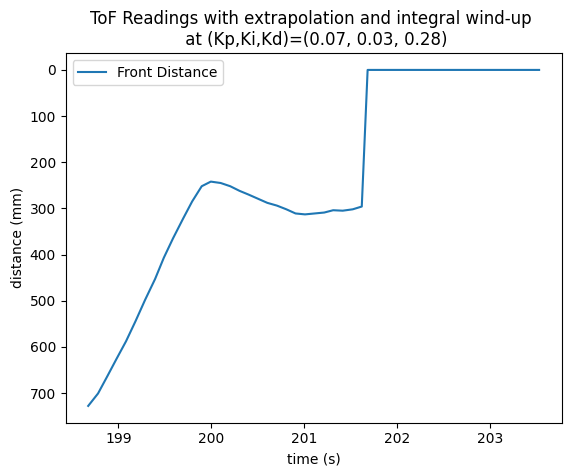

In [53]:
plt.plot(timeToF, distanceF, label = 'Front Distance')
plt.xlabel('time (s)')
plt.ylabel('distance (mm)')
plt.title('ToF Readings with extrapolation and integral wind-up \n at (Kp,Ki,Kd)=('+str(Kp)+", "+str(Ki)+", "+str(Kd)+")")
#plt.ylim([200,600])
plt.gca().invert_yaxis()
plt.legend();

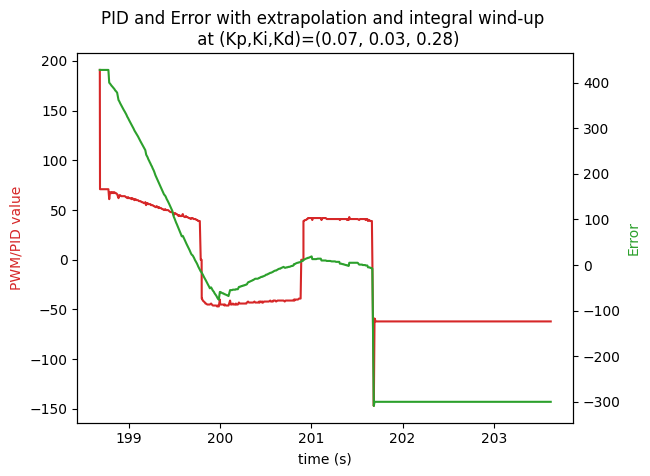

2024-04-15 20:12:56,159 | INFO     |: Disconnected from C0:89:C1:6D:24:4B


In [54]:
fig, ax1 = plt.subplots() 
color = 'tab:red'
ax1.set_xlabel('time (s)') 
ax1.set_ylabel('PWM/PID value', color = color) 
ax1.plot(timePID,PIDoutput, label = 'PID', color = color)
ax2 = ax1.twinx() 
color = 'tab:green'
ax2.set_ylabel('Error', color = color) 
ax2.plot(timePID,error, label = 'error', color = color)
plt.title('PID and Error with extrapolation and integral wind-up \n at (Kp,Ki,Kd)=('+str(Kp)+", "+str(Ki)+", "+str(Kd)+")")
plt.show();

In [34]:
s=38
c= str(s)+"|"+str(s/1.12)
ble.send_command(CMD.MOVE, c)

In [35]:
ble.send_command(CMD.MOVE, "0|0")

In [28]:
#Difference between consecutive time elements
samplingPeriod = [x - timeToF[i - 1] for i, x in enumerate(timeToF)][1:]
avg_samplingPeriod = np.mean(samplingPeriod) #in seconds
print(f"The sampling frequency is about {round(1/avg_samplingPeriod,3)} Hz")

The sampling frequency is about 9.804 Hz


In [10]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [11]:
# Disconnect
ble.disconnect()

2024-03-13 14:52:20,047 | INFO     |: Disconnected from C0:89:C1:6D:24:4B


In [26]:
distanceF

[0.0]

In [87]:

467+(467.0-468.0)/(27.817-27.722)/1000*299

463.85263157894735

2024-03-19 02:32:14,338 | INFO     |: Disconnected from C0:89:C1:6D:24:4B


In [30]:
str(0.015)

'0.015'